# Covid Challenge 2020

The Aim of this notebook is to predict the bed requirements across states in US as a measure to controll CoVID cases in a particular state


We believe medical professionals and government will be the key stakeholders for this project


The success measure is that the confidence interval of the predicted beds for a state is less than 100 for any state

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model

## Data sources :
#### Census Data,  IHME Data, Google Mobility,  NY Times articles, Worldometer.com


In [156]:
hospital = pd.read_excel("hospital_needs.xlsx")
population_den = pd.read_csv("population density.csv")
mobility = pd.read_excel("mobility_final.xlsx")
cases = pd.read_excel("us-states-cases.xlsx")
demographic = pd.read_excel("Demographic Raw Data.xlsx")

Demographic data set has details of age, gender and race which seems to be affect the CoVID spread

In [3]:
demographic.head()
demographic_subset = demographic.drop(["ID","Total population",
                        "Land Area (sq mi)","Male","Female","Under 5 years",
                        "5 to 9 years","5 to 9 years","10 to 14 years",
                        "15 to 19 years","20 to 24 years","25 to 34 years",
                        "35 to 44 years","45 to 54 years","55 to 59 years",
                        "60 to 64 years","65 to 74 years","75 to 84 years",
                        "75 to 84 years","85 years and over","RACE!!Total population","One White",
                        "One Black or African American","One American Indian and Alaska Native","Asian",
                        "One Native Hawaiian and Other Pacific Islander","One Some other race",
                        "HISPANIC OR LATINO AND Hispanic or Latino","Total housing units"],axis = 1)

The below visualization helps us see correlations between demographic data and the cases and deaths

In [4]:
latest_cases = cases[cases["date"] == "2020-04-11"]
latest_cases.head()

,date,state,fips (Govt. code),cases,deaths,State Groups
2026,2020-04-11,Alabama,1,3262,93,Middle -2
2027,2020-04-11,Alaska,2,255,6,Bottom
2028,2020-04-11,Arizona,4,3393,112,Middle -2
2029,2020-04-11,Arkansas,5,1228,25,Bottom
2030,2020-04-11,California,6,22421,632,Top


In [5]:
demographic_cases = pd.merge(latest_cases, demographic_subset, left_on = "state", right_on = "State", how = "inner")
corr_mat = demographic_cases.corr("pearson")

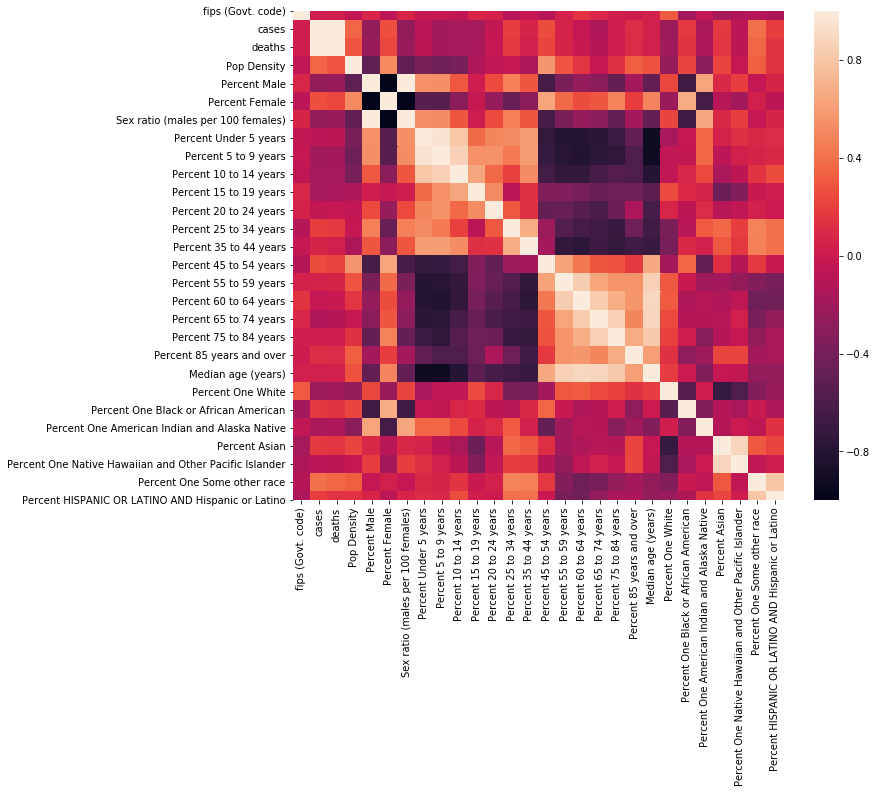

In [7]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_mat)

Social distancing is the only proven effective way to mitigate spread, social_dist is a dataframe which maps states to the lockdown dates 

Population density looks at density per square mile and the population of each states

In [8]:
social_dist = population_den[["State.1","Social distance start date"]]
population_den = population_den.iloc[:,0:4]
population_den.head()

,State,Density,Pop,LandArea
0,District of Columbia,11814.5410,720687,61
1,New Jersey,1215.1991,8936574,7354
2,Rhode Island,1021.4323,1056161,1034
3,Massachusetts,894.4355,6976597,7800
4,Connecticut,735.8689,3563077,4842


In [9]:
social_dist.head()

,State.1,Social distance start date
0,Alabama,4/4/2020
1,Alaska,3/28/2020
2,Arizona,3/31/2020
3,Arkansas,NaN
4,California,3/19/2020


## Trends

Looking at sinmle trend in all cases, more detailed trends are on the tableau dashboard in the github link

In [10]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Total infections', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

C:\Users\tkblu\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


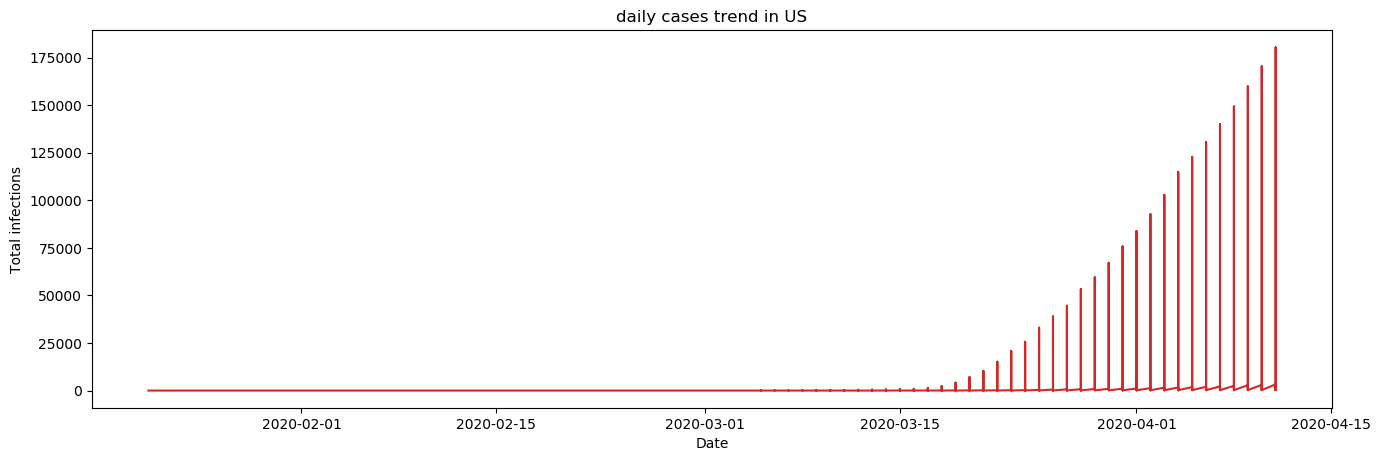

In [11]:
plot_df(cases, x = cases.date, y = cases.cases, title='daily cases trend in US')  

## Time series Analysis 

Given that the number of beds required on a day is a function of the number of days required the previous day
Due to the time series nature of the spread we will implement a state space mode to predict the future beds


The prediction is also indicative of the total infection 

## Hospital data set 

The below cells will combine the hospital data with population, social distancing and daily cases data to predict the new bed requirement

In [12]:
hospital_subset = hospital[["location_name","date","allbed_mean","ICUbed_mean",
                            "InvVen_mean","admis_mean","newICU_mean","totdea_mean",
                            "bedover_mean","icuover_mean"]]

In [13]:
hospital_pop = pd.merge(hospital_subset, population_den, left_on = "location_name", right_on = "State", how = "inner")
len(hospital_pop["location_name"].unique())
hospital_pop.head()

,location_name,date,allbed_mean,ICUbed_mean,InvVen_mean,admis_mean,newICU_mean,totdea_mean,bedover_mean,icuover_mean,State,Density,Pop,LandArea
0,Wyoming,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wyoming,5.84,567025,97093
1,Wyoming,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wyoming,5.84,567025,97093
2,Wyoming,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wyoming,5.84,567025,97093
3,Wyoming,2020-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wyoming,5.84,567025,97093
4,Wyoming,2020-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wyoming,5.84,567025,97093


In [15]:
hospital_pop_subset = hospital_pop[hospital_pop["date"] <= "2020-11-05"]
## We are limiting our study to 5th of April 
hospital_pop_social = pd.merge(hospital_pop_subset, social_dist, left_on = ["location_name"], right_on = ["State.1"], how = "inner")
## merging hospital and population data with social distancing data 

In [16]:
## simple date time operation to find the number of days since the social distancing lockdown 
hospital_pop_social["Social distance start date"] = pd.to_datetime(hospital_pop_social["Social distance start date"]) 
hospital_pop_social["social_dist_count"] = hospital_pop_social["date"] - hospital_pop_social["Social distance start date"]
hospital_pop_social.loc[hospital_pop_social["social_dist_count"] <  pd.Timedelta('0 days'),"social_dist_count"] = pd.Timedelta('0 days')
hospital_pop_social[hospital_pop_social["social_dist_count"] <  pd.Timedelta('0 days')]["social_dist_count"]

Series([], Name: social_dist_count, dtype: timedelta64[ns])

In [17]:
## removing unneccesary elements 
hospital_pop_social = hospital_pop_social.drop(["State.1"],axis = 1)

In [18]:
## merging hospital data with Covid cases data 
hospi_pop_soc_cases = pd.merge(hospital_pop_social, cases, 
                               left_on = ["location_name","date"], right_on = ["state","date"], 
                               how = "inner")

In [19]:
hospi_pop_soc_cases = hospi_pop_soc_cases.drop(["state"],axis = 1)

In [20]:
## removing unneccesary elements 
hospi_pop_soc_cases_all_bed = hospi_pop_soc_cases.drop(hospi_pop_soc_cases.columns[[3,4,5,6,7,8,9]], axis=1, inplace=False)

In [22]:
## merging hospital data with Demographic data 
hospi_pop_soc_cases_all_bed = pd.merge(hospi_pop_soc_cases_all_bed,
                                       demographic_subset,
                                      left_on = ["location_name"], right_on = ["State"],how = "inner")

In [23]:
## removing unneccesary elements 
hospi_pop_soc_cases_all_bed = hospi_pop_soc_cases_all_bed.drop(["State_x","State_y","fips (Govt. code)",
                                  "State Groups","Social distance start date"],axis=1)

In [24]:
hospi_pop_soc_cases_all_bed

,location_name,date,allbed_mean,Density,Pop,LandArea,social_dist_count,cases,deaths,State Group,...,Percent 75 to 84 years,Percent 85 years and over,Median age (years),Percent One White,Percent One Black or African American,Percent One American Indian and Alaska Native,Percent Asian,Percent One Native Hawaiian and Other Pacific Islander,Percent One Some other race,Percent HISPANIC OR LATINO AND Hispanic or Latino
0,Wyoming,2020-03-11,0.000000,5.8400,567025,97093,0 days,1,0,Bottom,...,4.8,1.6,38.5,91.5,0.6,2.801448,1.0,0.2,1.5,10.0
1,Wyoming,2020-03-12,0.000000,5.8400,567025,97093,0 days,1,0,Bottom,...,4.8,1.6,38.5,91.5,0.6,2.801448,1.0,0.2,1.5,10.0
2,Wyoming,2020-03-13,0.000000,5.8400,567025,97093,0 days,2,0,Bottom,...,4.8,1.6,38.5,91.5,0.6,2.801448,1.0,0.2,1.5,10.0
3,Wyoming,2020-03-14,0.000000,5.8400,567025,97093,0 days,3,0,Bottom,...,4.8,1.6,38.5,91.5,0.6,2.801448,1.0,0.2,1.5,10.0
4,Wyoming,2020-03-15,0.000000,5.8400,567025,97093,0 days,3,0,Bottom,...,4.8,1.6,38.5,91.5,0.6,2.801448,1.0,0.2,1.5,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071,Alabama,2020-04-07,453.147491,96.9221,4908621,50645,3 days,2197,64,Middle -2,...,5.1,1.7,39.3,67.7,26.7,0.451383,1.3,0.0,1.7,4.3
2072,Alabama,2020-04-08,507.371258,96.9221,4908621,50645,4 days,2499,67,Middle -2,...,5.1,1.7,39.3,67.7,26.7,0.451383,1.3,0.0,1.7,4.3
2073,Alabama,2020-04-09,513.796855,96.9221,4908621,50645,5 days,2838,78,Middle -2,...,5.1,1.7,39.3,67.7,26.7,0.451383,1.3,0.0,1.7,4.3
2074,Alabama,2020-04-10,600.716086,96.9221,4908621,50645,6 days,3008,80,Middle -2,...,5.1,1.7,39.3,67.7,26.7,0.451383,1.3,0.0,1.7,4.3


In [25]:
#setting social distance count as a number for the model
hospi_pop_soc_cases_all_bed["social_dist_count"] = hospi_pop_soc_cases_all_bed["social_dist_count"].dt.days

In [26]:
# setting date as a timeseries index 
hospi_pop_soc_cases_all_bed["date_index"] = (hospi_pop_soc_cases_all_bed["date"]-min(hospi_pop_soc_cases_all_bed["date"])).dt.days

In [27]:
# removing unneccesary elements 
hospi_pop_soc_cases_all_bed = hospi_pop_soc_cases_all_bed.drop(["date"],axis=1)

In [28]:
# State group as you will see in the tableau dashboard, the states are grouped by the number of cases
# NY and NJ have the highest cases 
# The top states are the states with cases 22,000 cases
# Botton states are the ones less than 3000 cases 
# Middle cases fall in between 
# this clusters was done purely visually as there was clear demarkation once ploted 
pd.unique(hospi_pop_soc_cases_all_bed["State Group"])

array(['Bottom', 'Middle -1', 'Middle -2', 'Top', 'Middle -3', 'NY & NJ'],
      dtype=object)

In [29]:
# state group mapping
hospi_pop_soc_cases_all_bed["State Group"] = hospi_pop_soc_cases_all_bed["State Group"].map({'NY & NJ': 5, 'Top': 4, 'Middle -1': 3, 'Middle -2': 2, 'Middle -3': 1, 'Bottom':0})

In [30]:
# check
pd.unique(hospi_pop_soc_cases_all_bed["State Group"])

array([0, 3, 2, 4, 1, 5], dtype=int64)

## Modelling - State space model with autoregession

In [31]:
# reassigning
input_df = hospi_pop_soc_cases_all_bed

In [32]:
# To check if all values are either int or float 
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2076 entries, 0 to 2075
Data columns (total 35 columns):
location_name                                             2076 non-null object
allbed_mean                                               2076 non-null float64
Density                                                   2076 non-null float64
Pop                                                       2076 non-null int64
LandArea                                                  2076 non-null int64
social_dist_count                                         1889 non-null float64
cases                                                     2076 non-null int64
deaths                                                    2076 non-null int64
State Group                                               2076 non-null int64
Pop Density                                               2076 non-null float64
Percent Male                                              2076 non-null float64
Percent Female          

In [33]:
# US states mapping
states = pd.unique(input_df.location_name)

In [34]:
# loop to map states
state_num = []
for state in states:
    state_num.append(sum(input_df.location_name==state))

In [35]:
# check 
min(state_num), max(state_num)

(26, 82)

In [36]:
## the columns in the final dataframe 
['allbed_mean', 'Density', 'Pop', 'LandArea', 'social_dist_count',
       'cases', 'deaths', 'State Group', 'Pop Density', 'Percent Male',
       'Percent Female', 'Sex ratio (males per 100 females)',
       'Percent Under 5 years', 'Percent 5 to 9 years',
       'Percent 10 to 14 years', 'Percent 15 to 19 years',
       'Percent 20 to 24 years', 'Percent 25 to 34 years',
       'Percent 35 to 44 years', 'Percent 45 to 54 years',
       'Percent 55 to 59 years', 'Percent 60 to 64 years',
       'Percent 65 to 74 years', 'Percent 75 to 84 years',
       'Percent 85 years and over', 'Median age (years)', 'Percent One White',
       'Percent One Black or African American',
       'Percent One American Indian and Alaska Native', 'Percent Asian',
       'Percent One Native Hawaiian and Other Pacific Islander',
       'Percent One Some other race',
       'Percent HISPANIC OR LATINO AND Hispanic or Latino']

['allbed_mean',
 'Density',
 'Pop',
 'LandArea',
 'social_dist_count',
 'cases',
 'deaths',
 'State Group',
 'Pop Density',
 'Percent Male',
 'Percent Female',
 'Sex ratio (males per 100 females)',
 'Percent Under 5 years',
 'Percent 5 to 9 years',
 'Percent 10 to 14 years',
 'Percent 15 to 19 years',
 'Percent 20 to 24 years',
 'Percent 25 to 34 years',
 'Percent 35 to 44 years',
 'Percent 45 to 54 years',
 'Percent 55 to 59 years',
 'Percent 60 to 64 years',
 'Percent 65 to 74 years',
 'Percent 75 to 84 years',
 'Percent 85 years and over',
 'Median age (years)',
 'Percent One White',
 'Percent One Black or African American',
 'Percent One American Indian and Alaska Native',
 'Percent Asian',
 'Percent One Native Hawaiian and Other Pacific Islander',
 'Percent One Some other race',
 'Percent HISPANIC OR LATINO AND Hispanic or Latino']

Function that takes a window of time: 
Start window indicating the start date for the model and window size is the length of the time frame (taking week for this model)

output of this function is 

In [115]:

def get_time_window(df, state, window_size=7, start_window=0, only_ar=False):
    df = df[df.location_name==state]
    df = df.sort_values("date_index").drop(["location_name","date_index"],axis=1)
    
    df_np = df.to_numpy()
    row_num = df_np.shape[0]

    if only_ar:
        output = df_np[window_size:,:1].copy()
    else:
        output = df_np[window_size:].copy()
    for i in range(start_window, window_size):
        output = np.concatenate([output, df_np[i:row_num-window_size+i,:1]], axis=1)

    return output
  

In [38]:
# social distancing marked as -1 for states where its not enforeced 

input_df["social_dist_active"] = 1
input_df.loc[pd.isnull(input_df["social_dist_count"]),"social_dist_active"] = 0
input_df.loc[pd.isnull(input_df["social_dist_count"]),"social_dist_count"] = -1

In [142]:
np_mat_list = []
for state in states:
    np_mat_list.append(get_time_window(input_df, state,7,0, only_ar=False))

In [143]:
all_mat = np.concatenate(np_mat_list)

In [144]:
all_mat.shape

(1726, 41)

In [145]:
#check not null
np.mean(all_mat)


199654.70713097753

In [146]:
# linear auto regression function with ridge regularization
def run_lin_reg(X, y, alpha=.5):
    mean_X = np.mean(X, axis=0)
    var_X = np.var(X, axis=0)
    norm_X = (X-mean_X)/var_X
    
    mean_y = np.mean(y)
    var_y = np.var(y)
    norm_y = (y-mean_y)/var_y
    reg = linear_model.Ridge(alpha = alpha)
    reg.fit(norm_X, norm_y)
    return mean_X, var_X, mean_y, var_y, reg

def run_inference(X, mean_X, var_X, mean_y, var_y, reg):
    norm_X = (X-mean_X)/var_X
    return reg.predict(norm_X)*var_y + mean_y

# Key KPI for our model 
def mean_square_error(y, y_hat):
    return (np.sum((y-y_hat)**2)/y.shape[0])**0.5

In [147]:
X, y  = all_mat[:,1:], all_mat[:,0]

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mean_X, var_X, mean_y, var_y, reg = run_lin_reg(X_train, y_train, alpha=0.00000001)

In [149]:
y_train_pred = run_inference(X_train, mean_X, var_X, mean_y, var_y, reg)
mean_square_error(y_train, y_train_pred)

69.91565398537392

In [150]:
y_test_pred = run_inference(X_test, mean_X, var_X, mean_y, var_y, reg)
mean_square_error(y_test, y_test_pred)

84.92007761063371

In [151]:
y_y_hat = np.stack([y_train,y_train_pred],axis=1)

In [152]:
y_y_hat_new = y_y_hat[y_y_hat[:,0].argsort(kind='mergesort')]

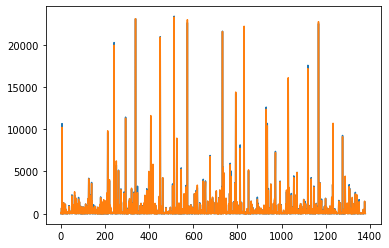

In [153]:
plt.plot(y_y_hat)

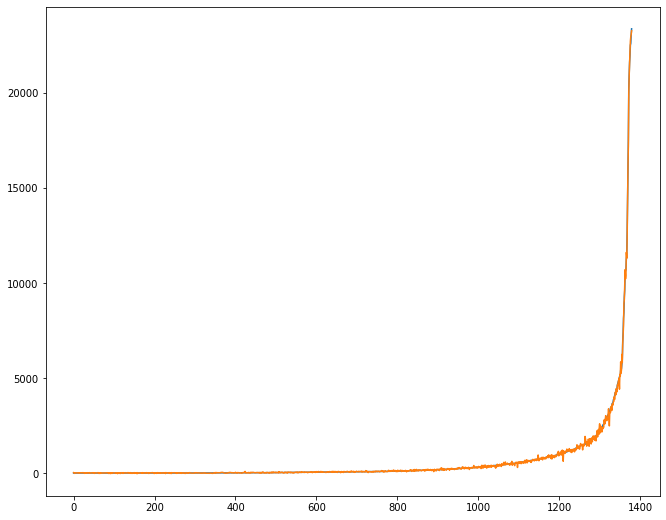

In [159]:
# we see that the predicted (orange) and actual(blue) values co-incinde to a large entent in the below graph indicating KPI success 
f, ax = plt.subplots(figsize=(11, 9))
plt.plot(y_y_hat_new)